# DETR Model를 이용하여 Object Detection 구현하기

- COCO darasets을 이용하였다.  

In [1]:
# 1. Import Module
import os, sys
import random
import itertools
import io
import math
import pandas as pd
import numpy as np
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from PIL import Image

In [2]:
# 2. Make COCO dataset
# COCO classes (91개)
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [7]:
# 3. Preprocessing and bounding box
# standard PyTorch mean-std input image normalization
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [8]:
# 4. Detection
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [11]:
# 5. Make Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device) # GPU

detr_101 = torch.hub.load('facebookresearch/detr:main', 'detr_resnet101', pretrained=True) # Use resnet 101
detr_101.eval()

cuda


Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

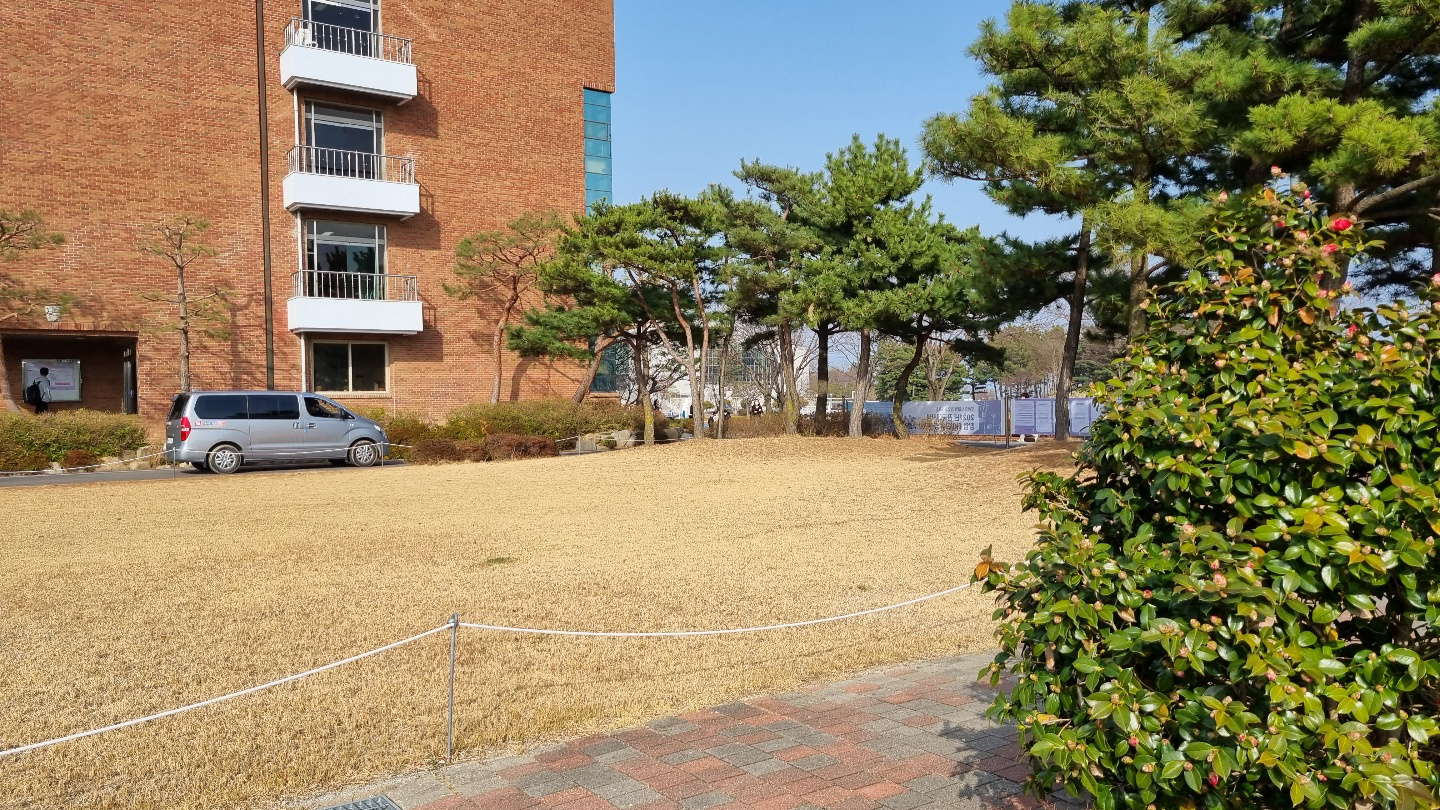

In [10]:
# 6. Test Image
img2 = Image.open('./handong_place2.jpg')
img2

In [12]:
scores, boxes = detect(img2, detr_101, transform)

#### boxes = > 각 label에 대해서 (xmin, ymin, xmax, ymax)의 좌표값을 전달한다.

In [13]:
scores, boxes

(tensor([[1.8417e-10, 1.2990e-05, 1.0613e-06, 9.9819e-01, 5.7601e-06, 1.2898e-06,
          3.3213e-05, 3.1344e-07, 1.5522e-04, 1.9069e-06, 4.8121e-07, 1.9908e-07,
          1.3446e-10, 1.4808e-06, 4.6021e-06, 4.3649e-06, 1.4994e-07, 1.4581e-07,
          7.2365e-07, 1.7756e-07, 1.3062e-05, 9.7726e-07, 4.0851e-08, 2.9039e-10,
          8.1980e-06, 1.9946e-08, 2.0816e-10, 2.3174e-07, 1.2392e-06, 1.8643e-10,
          1.9664e-10, 9.7441e-08, 2.4764e-10, 9.3410e-08, 6.8718e-07, 8.9084e-09,
          7.8647e-10, 2.4124e-06, 2.6515e-07, 1.5381e-09, 1.0187e-07, 8.4151e-08,
          3.4233e-09, 1.1610e-07, 1.3984e-09, 1.5760e-10, 2.3745e-08, 9.7305e-07,
          3.0742e-10, 3.1423e-11, 2.8938e-09, 1.1269e-06, 1.1018e-08, 8.7060e-07,
          1.3448e-08, 1.2891e-06, 2.3774e-08, 3.8891e-10, 8.5897e-10, 3.4049e-07,
          5.8273e-07, 2.3299e-10, 4.8322e-06, 2.2737e-06, 1.0588e-06, 9.6246e-09,
          1.6214e-10, 1.0949e-06, 1.3275e-10, 1.0998e-10, 1.6405e-07, 2.1818e-10,
          1.1991

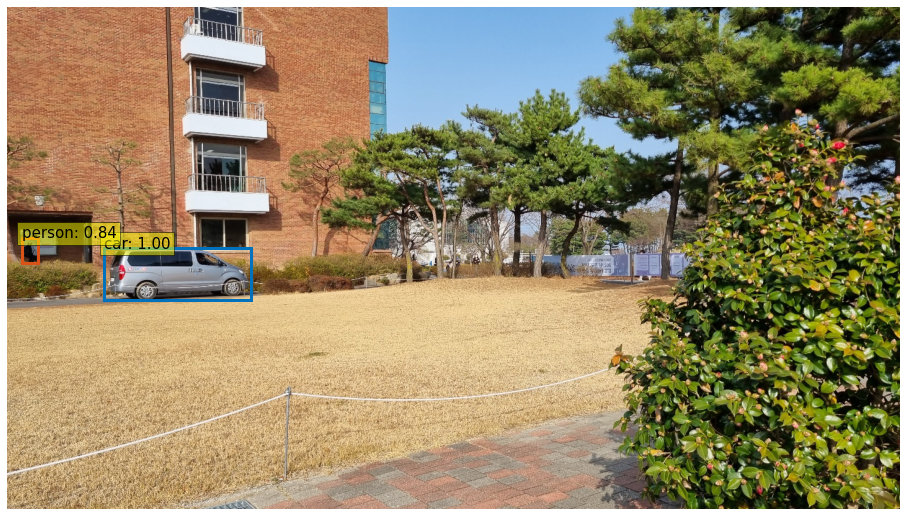

In [14]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img2, scores, boxes)

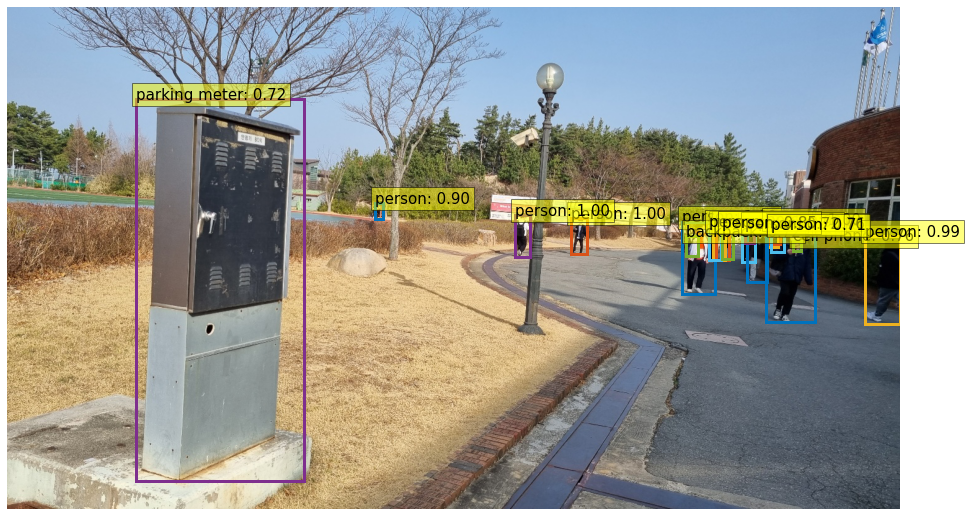

In [16]:
img1 = Image.open('./handong_place.jpg')
scores, boxes = detect(img1, detr_101, transform)
plot_results(img1, scores, boxes)